In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("bmh")

In [70]:
train = pd.read_csv("train.csv")
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


# Major Attempt 1 - Combining/grouping as much as possible

### Grouping facility_type based on mean site_eui and encoding State_Factor and building_class

In [71]:
facility_means = train.groupby("facility_type").mean()["site_eui"]

In [72]:
# mean thresholds: >=150 (4), >=100 (3), >=50 (2), <= 50 (1)
def facility_type_group(facility_type):
    mean = facility_means[facility_type]
    return min(mean // 50 + 1, 4)

train["facility_type"] = train["facility_type"].apply(facility_type_group).astype("int64")

In [73]:
def strip_state(string):
    # convert State_X to X
    return int(string.lstrip("State_"))
train["State_Factor"] = train["State_Factor"].apply(strip_state)
train["building_class"] = train["building_class"].apply(lambda x: 1 if x == "Residential" else 0)

In [74]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,1,0,4,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,1,0,1,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,1,0,3,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,1,0,2,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,1,0,1,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [75]:
train[["facility_type", "site_eui"]].corr()

,facility_type,site_eui
facility_type,1.000000,0.422959
site_eui,0.422959,1.000000


### Missing + Strange Values

Wind Speed - more than half of the values are missing for direction_max_wind_speed, direction_peak_wind_speed and max_wind_speed, and the correlations for all three are low, so we can drop them.

Days with Fog - same as above.

Year Built - there are a few years that are missing and also a few years that are 0. We can replace them with the minimum year.

Energy Star Rating - we can replace the missing values with the mean value

In [76]:
train.drop(["direction_max_wind_speed", "direction_peak_wind_speed", 
            "max_wind_speed", "days_with_fog"], axis=1, inplace=True)
train["year_built"].replace(0, train[train["year_built"] > 0]["year_built"].min(), inplace=True)
train["year_built"].fillna(train["year_built"].min(), inplace=True)
train["energy_star_rating"].fillna(train["energy_star_rating"].mean(), inplace=True)

## Feature Selection + Testing Effectiveness with XGBoost and LightGBMRegressor

In [77]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [78]:
features = train.drop(["site_eui", "id"], axis=1)
target = train["site_eui"]
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size = 0.2, random_state=0)

### Lasso Regression

In [79]:
from sklearn import linear_model
lasso = linear_model.LassoLarsCV(max_iter = 20000)
lasso.fit(X_train, y_train)
preds = lasso.predict(X_val)
print(mean_squared_error(y_val, preds, squared=False))
plt.figure(figsize=(14, 6))
features.columns[lasso.coef_ != 0]

50.09940935820283


Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'march_avg_temp', 'march_max_temp', 'april_max_temp', 'may_min_temp',
       'june_min_temp', 'june_max_temp', 'july_min_temp', 'july_max_temp',
       'august_min_temp', 'august_avg_temp', 'august_max_temp',
       'september_min_temp', 'september_max_temp', 'october_min_temp',
       'october_max_temp', 'november_min_temp', 'november_max_temp',
       'december_min_temp', 'cooling_degree_days', 'precipitation_inches',
       'snowfall_inches', 'snowdepth_inches', 'days_below_30F',
       'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F',
       'days_above_90F', 'days_above_100F', 'days_above_110F'],
      dtype='object')

<Figure size 1008x432 with 0 Axes>

In [80]:
train.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

### Highly Correlated Values

In [81]:
corr = train.corr()

In [82]:
# for each of the months, choose one column out of min, avg, and max to represent the temperature
for month in ["january", "february", "march", "april", "may", "june", "july", "august", "september", 
              "october", "november", "december"]:
    min_col = f"{month}_min_temp"
    avg_col = f"{month}_avg_temp"
    max_col = f"{month}_max_temp"
    best_col = min_col
    for col in [avg_col, max_col]:
        if corr[col]["site_eui"] > corr[best_col]["site_eui"]:
            best_col = col
    for col in [min_col, avg_col, max_col]:
        if best_col != col:
            features.drop(col, axis=1, inplace=True)

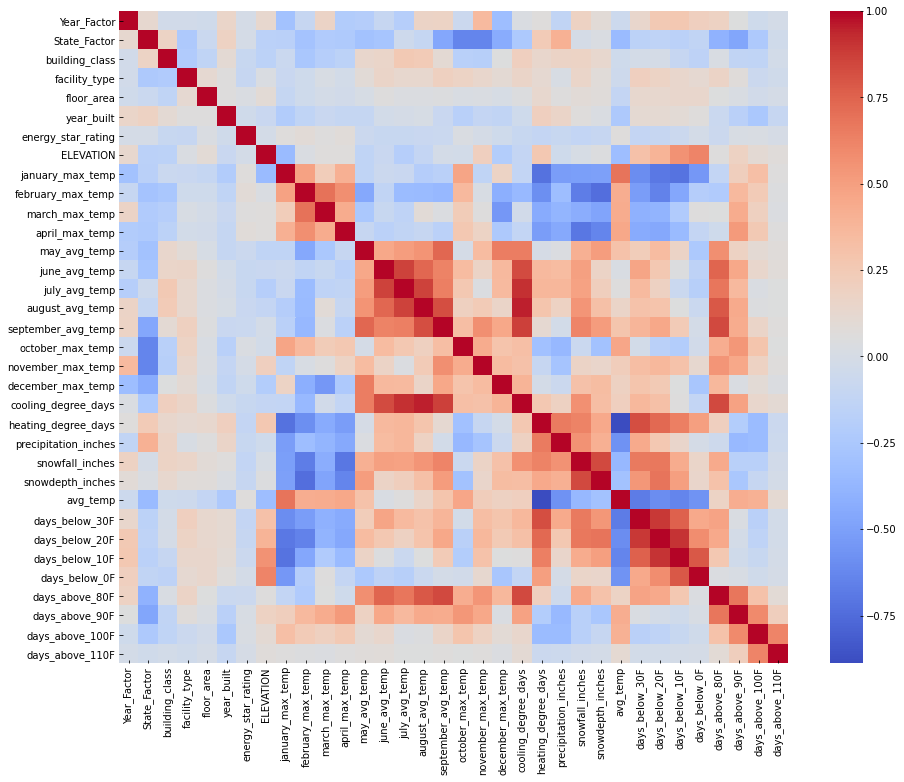

In [88]:
plt.figure(1, figsize=(15, 12))
corr = features.corr()
sns.heatmap(corr, cmap="coolwarm")

In [84]:
# train.drop([col for col in train.columns if "_temp" in col], axis=1, inplace=True)

In [85]:
# train.drop([col for col in train.columns if "days_below" in col or "days_above" in col], axis=1, inplace=True)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size = 0.2, random_state=0)

In [117]:
gbm_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [4000, 5000, 6000],
    'max_depth' : [9, 11, 13]
    }


clf = lgb.LGBMRegressor()
gbm_search = RandomizedSearchCV(clf,gbm_params,verbose=1,n_iter=15)
gbm_search.fit(X_train,y_train)
# gbm.fit(X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         eval_metric='l1',
#         callbacks=[lgb.early_stopping(5)])


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 676.1min finished


RandomizedSearchCV(estimator=LGBMRegressor(), n_iter=15,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [9, 11, 13],
                                        'n_estimators': [4000, 5000, 6000]},
                   verbose=1)

In [121]:
print('Starting predicting...')
# predict
preds = gbm_search.predict(X_val)
# eval
print(mean_squared_error(y_val, preds, squared=False))

# feature importances
print(f'Feature importances: {list(gbm_search.best_estimator_.feature_importances_)}')

Starting predicting...
42.396310628189724
Feature importances: [1009, 972, 2918, 5620, 31305, 27900, 15092, 8554, 2186, 1079, 1617, 903, 1589, 1620, 1664, 1081, 1458, 851, 1307, 980, 356, 1078, 1519, 773, 641, 1034, 1293, 334, 1470, 232, 729, 644, 146, 0]


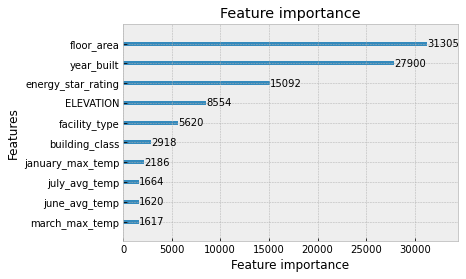

In [122]:
lgb.plot_importance(gbm_search.best_estimator_, max_num_features=10)

In [102]:
estimator = xgb.XGBRegressor(objective ='reg:squarederror')
xgboost_params = {
    "max_depth": [3, 4, 5, 6],
    "alpha": [0.01, 0.1, 1, 10],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 150, 200]
}



In [103]:
grid_search = RandomizedSearchCV(estimator, xgboost_params, n_jobs = 10, cv = 5, verbose=True, n_iter = 15)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:  7.0min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [104]:
best_xgb = grid_search.best_estimator_
preds = best_xgb.predict(X_val)
mean_squared_error(y_val, preds, squared=False)

41.53604052427474

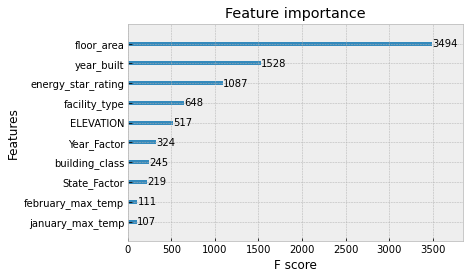

In [105]:
xgb.plot_importance(best_xgb, max_num_features=10)

In [123]:
test = pd.read_csv("test.csv")
test["facility_type"] = test["facility_type"].apply(facility_type_group).astype("int64")
test["State_Factor"] = test["State_Factor"].apply(strip_state)
test["building_class"] = test["building_class"].apply(lambda x: 1 if x == "Residential" else 0)
test["year_built"].replace(0, train["year_built"].min(), inplace=True)
test["year_built"].fillna(train["year_built"].min(), inplace=True)
test["energy_star_rating"].fillna(train["energy_star_rating"].mean(), inplace=True)

In [124]:
Xtest = test[features.columns]
test["site_eui"] = gbm_search.best_estimator_.predict(Xtest, num_iteration=gbm.best_iteration_)
test = test[["id", "site_eui"]]
test.to_csv("gbm_submission.csv", index=None)

In [112]:
test["site_eui"] = best_xgb.predict(Xtest)
test = test[["id", "site_eui"]]
test.to_csv("xgb_submission.csv", index=None)

# Major Attempt 2 - leaving more of the data as is

In [194]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Label Encoding Categorical Variables

In [195]:
from sklearn.preprocessing import LabelEncoder
for col in ["State_Factor", "building_class", "facility_type"]:
    encoder = LabelEncoder()
    encoder.fit(train[col])
    train[col] = encoder.transform(train[col])

    for label in np.unique(test[col]):
        if label not in encoder.classes_: 
            encoder.classes_ = np.append(encoder.classes_, label) 
    test[col] = encoder.transform(test[col])

In [196]:
# state_factor_means = train.groupby("State_Factor").median()["site_eui"].to_dict()
# train = train.replace({"State_Factor": state_factor_means})
# test = test.replace({"State_Factor": state_factor_means})
# print(state_factor_means)

# building_class_means = train.groupby("building_class").median()["site_eui"].to_dict()
# train = train.replace({"building_class": building_class_means})
# test = test.replace({"building_class": building_class_means})
# print(building_class_means)


# facility_type_means = train.groupby("facility_type").median()["site_eui"].to_dict()
# train = train.replace({"facility_type": facility_type_means})
# test = test.replace({"facility_type": facility_type_means})
# print(facility_type_means)

In [197]:
train.describe()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,75757.000000,75757.000000,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,4.237998,0.574970,25.931914,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,1.549536,0.494351,11.645404,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,0.000000,0.000000,0.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,4.000000,0.000000,27.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,5.000000,1.000000,27.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,5.000000,1.000000,30.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.000000,1.000000,59.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


In [198]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,0,0,13,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,0,0,55,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,0,0,48,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,0,0,6,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,0,0,56,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [204]:
features = train.drop(["id", "site_eui"], axis=1)
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size = 0.2, random_state=0)
gbm_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [4000, 5000, 6000],
    'max_depth' : [9, 11, 13]
    }


clf = lgb.LGBMRegressor()
gbm_search = RandomizedSearchCV(clf,gbm_params,verbose=1,n_iter=15)
gbm_search.fit(X_train,y_train)
# gbm.fit(X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         eval_metric='l1',
#         callbacks=[lgb.early_stopping(5)])


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 61.3min finished


RandomizedSearchCV(estimator=LGBMRegressor(), n_iter=15,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [9, 11, 13],
                                        'n_estimators': [4000, 5000, 6000]},
                   verbose=1)

In [205]:
print('Starting predicting...')
# predict
preds = gbm_search.predict(X_val)
# eval
print(mean_squared_error(y_val, preds, squared=False))

# feature importances
print(f'Feature importances: {list(gbm_search.best_estimator_.feature_importances_)}')

Starting predicting...
40.52534831602415
Feature importances: [540, 586, 1522, 12791, 26803, 26388, 16756, 5336, 694, 2083, 525, 500, 359, 616, 289, 459, 744, 415, 706, 450, 446, 638, 657, 592, 591, 541, 486, 756, 383, 258, 471, 257, 867, 640, 496, 350, 637, 283, 465, 628, 812, 277, 354, 523, 138, 250, 794, 412, 268, 405, 332, 91, 103, 57, 308, 313, 28, 0, 970, 361, 782, 3344]


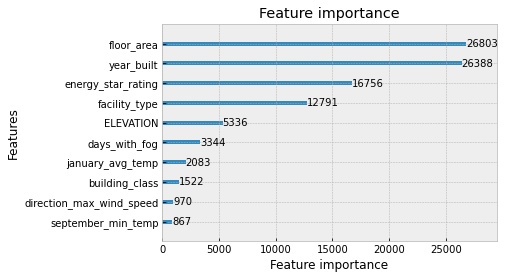

In [206]:
lgb.plot_importance(gbm_search.best_estimator_, max_num_features=10)

In [207]:
Xtest

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_max_temp,february_max_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,7,0,0,13,28484.0,1994.0,37.0,2.4,64,66,...,0,59.894521,0,0,0,0,29,5,2,0
1,7,0,0,13,21906.0,1961.0,55.0,45.7,64,66,...,0,59.894521,0,0,0,0,29,5,2,0
2,7,0,0,13,16138.0,1950.0,1.0,59.1,64,66,...,0,59.894521,0,0,0,0,29,5,2,0
3,7,0,0,13,97422.0,1971.0,34.0,35.4,64,66,...,0,59.894521,0,0,0,0,29,5,2,0
4,7,0,0,13,61242.0,1942.0,35.0,1.8,64,66,...,0,59.894521,0,0,0,0,29,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,2,1,1,305925.0,2013.0,99.0,812.0,54,59,...,10,53.420548,17,0,0,0,39,3,0,0
9701,7,2,1,1,34909.0,1910.0,94.0,26.5,54,59,...,10,53.420548,17,0,0,0,39,3,0,0
9702,7,2,1,1,42393.0,2014.0,94.0,812.0,54,59,...,10,53.420548,17,0,0,0,39,3,0,0
9703,7,2,1,1,25368.0,1992.0,79.0,812.0,54,59,...,10,53.420548,17,0,0,0,39,3,0,0


In [208]:
features.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [209]:
Xtest = test[features.columns]
test["site_eui"] = gbm_search.best_estimator_.predict(Xtest, num_iteration=gbm.best_iteration_)
test = test[["id", "site_eui"]]
test.to_csv("gbm_submission.csv", index=None)

In [210]:
test

,id,site_eui
0,75757,259.983366
1,75758,200.882872
2,75759,361.620513
3,75760,242.448548
4,75761,262.145353
...,...,...
9700,85457,28.180928
9701,85458,35.905302
9702,85459,30.843479
9703,85460,29.167072


In [211]:
otherTest = pd.read_csv("xgb_submission.csv")
otherTest

,id,site_eui
0,75757,260.027860
1,75758,280.181730
2,75759,299.555450
3,75760,281.899500
4,75761,279.279400
...,...,...
9700,85457,9.708085
9701,85458,59.957947
9702,85459,69.131290
9703,85460,76.588760
